In [38]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
import scipy.stats
import statistics

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

usedu_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

*** 
# Handling missing data

In [3]:
usedu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

In [4]:
usedu_df.isnull().sum()/usedu_df.shape[0]*100

PRIMARY_KEY                      0.000000
STATE                            0.000000
YEAR                             0.000000
ENROLL                          17.627346
TOTAL_REVENUE                   14.209115
FEDERAL_REVENUE                 14.209115
STATE_REVENUE                   14.209115
LOCAL_REVENUE                   14.209115
TOTAL_EXPENDITURE               14.209115
INSTRUCTION_EXPENDITURE         14.209115
SUPPORT_SERVICES_EXPENDITURE    14.209115
OTHER_EXPENDITURE               17.627346
CAPITAL_OUTLAY_EXPENDITURE      14.209115
GRADES_PK_G                     11.595174
GRADES_KG_G                      8.847185
GRADES_4_G                       8.780161
GRADES_8_G                       8.780161
GRADES_12_G                      8.780161
GRADES_1_8_G                     8.780161
GRADES_9_12_G                    8.780161
GRADES_ALL_G                    11.595174
AVG_MATH_4_SCORE                64.075067
AVG_MATH_8_SCORE                64.343164
AVG_READING_4_SCORE             64

### Dealing with missing values strategy:
- AVG_MATH & AVG_ READING columns are missing the majority of the data (65%). The data from these columns can be used to answer specific question about certain states where this proportion of data could be satisfactory to represent of the population. Otherwise, these columns can be eliminated from consideration.

In [5]:
# ncol = usedu_df.shape[1]
# cols = list(range(ncol-4, ncol))
# usedu_df.drop( usedu_df.columns[cols], axis=1, inplace=True)
usedu_df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


- Enrollment data is missing for 2012. Let's look at the distribution of number of enrolled students for a particular state and see how much variability there is accross the years

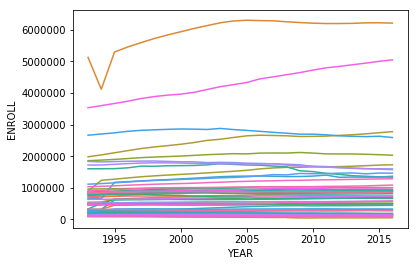

In [6]:
example_state = 'CALIFORNIA'
ax = sns.lineplot(x='YEAR', y='ENROLL', hue='STATE', data=usedu_df[(usedu_df['ENROLL'].notnull())], legend=False)


- Almost all states have a steady enrollment. Therefore, using mean to replace missing values would be a safe choice.

In [7]:
usedu_df['ENROLL'] = usedu_df.groupby('STATE')['ENROLL'].transform(lambda x: x.fillna(x.mean()))
pd.isnull(usedu_df.ENROLL).sum()/usedu_df.shape[0]*100

10.79088471849866

- The remaining 10% could be small districts/ 'states' that don't have a mean. How many other values are missing for these districts?

In [8]:
# subset of rows with ENROLL still Null
usedu_null_df = usedu_df[usedu_df['ENROLL'].isnull()]
print('{} row in this DataFrame subset'.format(usedu_null_df.shape[0]))
# percent of null per column for this subset
usedu_null_df.isnull().sum()/usedu_null_df.shape[0]*100

161 row in this DataFrame subset


PRIMARY_KEY                       0.000000
STATE                             0.000000
YEAR                              0.000000
ENROLL                          100.000000
TOTAL_REVENUE                   100.000000
FEDERAL_REVENUE                 100.000000
STATE_REVENUE                   100.000000
LOCAL_REVENUE                   100.000000
TOTAL_EXPENDITURE               100.000000
INSTRUCTION_EXPENDITURE         100.000000
SUPPORT_SERVICES_EXPENDITURE    100.000000
OTHER_EXPENDITURE               100.000000
CAPITAL_OUTLAY_EXPENDITURE      100.000000
GRADES_PK_G                      37.267081
GRADES_KG_G                      18.633540
GRADES_4_G                       18.012422
GRADES_8_G                       18.012422
GRADES_12_G                      18.012422
GRADES_1_8_G                     18.012422
GRADES_9_12_G                    18.012422
GRADES_ALL_G                     37.267081
AVG_MATH_4_SCORE                100.000000
AVG_MATH_8_SCORE                100.000000
AVG_READING

- These rows are missing all financial data and any analysis that concerns financial concepts should disregard these enteries.

In [9]:
print('nrow before= {}'.format(usedu_df.shape[0]))
usedu_df = usedu_df.drop( usedu_null_df.index.tolist() )
print('nrow after= {}'.format(usedu_df.shape[0]))

nrow before= 1492
nrow after= 1331


***
- Check how many values are still missing

In [10]:
usedu_df.isnull().sum()/usedu_df.shape[0]*100

PRIMARY_KEY                      0.000000
STATE                            0.000000
YEAR                             0.000000
ENROLL                           0.000000
TOTAL_REVENUE                    3.831705
FEDERAL_REVENUE                  3.831705
STATE_REVENUE                    3.831705
LOCAL_REVENUE                    3.831705
TOTAL_EXPENDITURE                3.831705
INSTRUCTION_EXPENDITURE          3.831705
SUPPORT_SERVICES_EXPENDITURE     3.831705
OTHER_EXPENDITURE                7.663411
CAPITAL_OUTLAY_EXPENDITURE       3.831705
GRADES_PK_G                      8.489857
GRADES_KG_G                      7.663411
GRADES_4_G                       7.663411
GRADES_8_G                       7.663411
GRADES_12_G                      7.663411
GRADES_1_8_G                     7.663411
GRADES_9_12_G                    7.663411
GRADES_ALL_G                     8.489857
AVG_MATH_4_SCORE                59.729527
AVG_MATH_8_SCORE                60.030053
AVG_READING_4_SCORE             59

In [11]:
# Missing financial values can be filled with corresponding mean of the state
 
revenue_cols = [col for col in usedu_df.columns if 'REVENUE' in col]
expenditure_cols = [col for col in usedu_df.columns if 'EXPENDITURE' in col]
before_impute = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).values
usedu_df[revenue_cols] = usedu_df.groupby(['STATE'])[revenue_cols].transform(lambda x: x.fillna(x.mean()))
usedu_df[expenditure_cols] = usedu_df.groupby(['STATE'])[expenditure_cols].transform(lambda x: x.fillna(x.mean()))
after_impute = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).values
impute_ind = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).index
for row in zip(impute_ind, before_impute, after_impute):
    print('{0:<30}      {1:<12}      {2:<12}'.format(*row))


PRIMARY_KEY                         0.0               0.0         
STATE                               0.0               0.0         
YEAR                                0.0               0.0         
ENROLL                              0.0               0.0         
TOTAL_REVENUE                       3.831705484598046      0.0         
FEDERAL_REVENUE                     3.831705484598046      0.0         
STATE_REVENUE                       3.831705484598046      0.0         
LOCAL_REVENUE                       3.831705484598046      0.0         
TOTAL_EXPENDITURE                   3.831705484598046      0.0         
INSTRUCTION_EXPENDITURE             3.831705484598046      0.0         
SUPPORT_SERVICES_EXPENDITURE        3.831705484598046      0.0         
OTHER_EXPENDITURE                   7.663410969196092      0.0         
CAPITAL_OUTLAY_EXPENDITURE          3.831705484598046      0.0         
GRADES_PK_G                         8.489857250187828      8.489857250187828
GRADES_

### Grade values is essential data that cannot be filled in

*** 
# Handling outliers

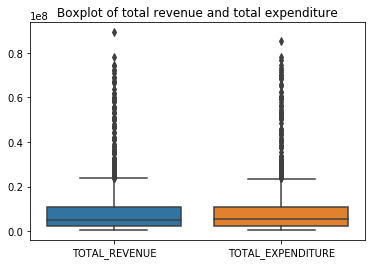

In [12]:
# visualizing outliers of TOTAL REVENUE/ EXPENDITURE

sns.boxplot(data= usedu_df[['TOTAL_REVENUE','TOTAL_EXPENDITURE']])
plt.title('Boxplot of total revenue and total expenditure')
plt.show()

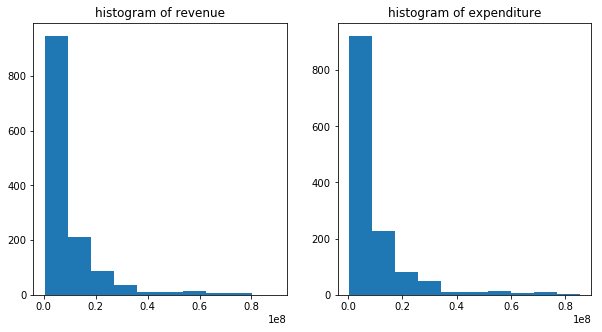

In [13]:
# histograms of TOTAL REVENUE/ EXPENDITURE
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.hist(usedu_df['TOTAL_REVENUE'])
plt.title("histogram of revenue")

plt.subplot(1, 2, 2)
plt.hist(usedu_df['TOTAL_EXPENDITURE'])
plt.title("histogram of expenditure")

plt.show()


In [14]:
# z-score test

rev_z_scores = zscore(usedu_df['TOTAL_REVENUE'])
print('Total revenue outliers:')
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(rev_z_scores > threshold)[0]))))

print('_____________________________________________')
exp_z_scores = zscore(usedu_df['TOTAL_EXPENDITURE'])
print('Total expenditure outliers:')
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(exp_z_scores > threshold)[0]))))

Total revenue outliers:
The score threshold is: 1
Number of outliers is: 140
The score threshold is: 2
Number of outliers is: 55
The score threshold is: 3
Number of outliers is: 39
The score threshold is: 4
Number of outliers is: 21
_____________________________________________
Total expenditure outliers:
The score threshold is: 1
Number of outliers is: 140
The score threshold is: 2
Number of outliers is: 56
The score threshold is: 3
Number of outliers is: 40
The score threshold is: 4
Number of outliers is: 23


In [15]:
# Tukey's method for outliers

q75, q25 = np.percentile(usedu_df['TOTAL_REVENUE'] , [75 ,25])
iqr = q75 - q25

print('Total revenue outliers:')
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((usedu_df['TOTAL_REVENUE'] > max_val) | (usedu_df['TOTAL_REVENUE'] < min_val))[0])) ))

print('_____________________________________________')
q75, q25 = np.percentile(usedu_df['TOTAL_EXPENDITURE'], [75 ,25])
iqr = q75 - q25

print('Total expenditure outliers:')
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((usedu_df['TOTAL_EXPENDITURE'] > max_val) | (usedu_df['TOTAL_EXPENDITURE'] < min_val))[0])) ))

Total revenue outliers:
The score threshold is: 1.0
Number of outliers is: 153
The score threshold is: 1.5
Number of outliers is: 113
The score threshold is: 2.0
Number of outliers is: 77
The score threshold is: 2.5
Number of outliers is: 55
The score threshold is: 3.0
Number of outliers is: 48
The score threshold is: 3.5
Number of outliers is: 42
The score threshold is: 4.0
Number of outliers is: 38
The score threshold is: 4.5
Number of outliers is: 33
_____________________________________________
Total expenditure outliers:
The score threshold is: 1.0
Number of outliers is: 159
The score threshold is: 1.5
Number of outliers is: 114
The score threshold is: 2.0
Number of outliers is: 83
The score threshold is: 2.5
Number of outliers is: 58
The score threshold is: 3.0
Number of outliers is: 52
The score threshold is: 3.5
Number of outliers is: 45
The score threshold is: 4.0
Number of outliers is: 40
The score threshold is: 4.5
Number of outliers is: 36


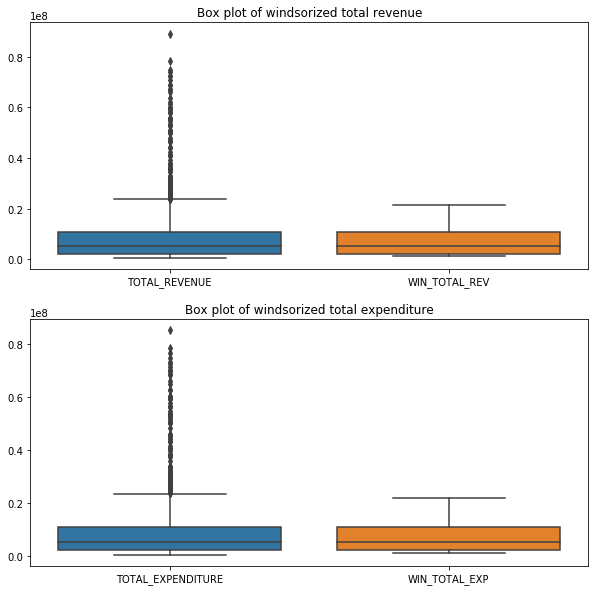

In [16]:
# Winsorization
plt.figure(figsize = (10,10))
winsorized_rev = winsorize(usedu_df['TOTAL_REVENUE'], (0.10, 0.10))
winsorized_exp = winsorize(usedu_df['TOTAL_EXPENDITURE'], (0.10, 0.10))

plt.subplot(2,1,1)
df = pd.DataFrame(list(zip(usedu_df['TOTAL_REVENUE'], winsorized_rev)), columns =['TOTAL_REVENUE', 'WIN_TOTAL_REV']) 
sns.boxplot(data=df)
plt.title("Box plot of windsorized total revenue")

plt.subplot(2,1,2)
df = pd.DataFrame(list(zip(usedu_df['TOTAL_EXPENDITURE'], winsorized_exp)), columns =['TOTAL_EXPENDITURE', 'WIN_TOTAL_EXP']) 
sns.boxplot(data=df)
plt.title("Box plot of windsorized total expenditure")
plt.show()

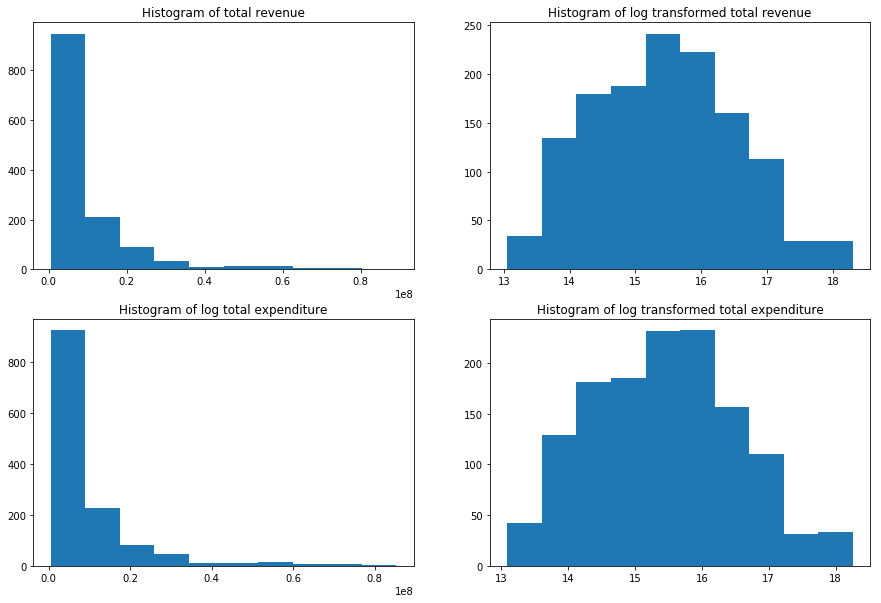

In [17]:
# Log transofrmation
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
plt.hist(usedu_df['TOTAL_REVENUE'])
plt.title("Histogram of total revenue")

plt.subplot(2,2,2)
plt.hist(np.log(usedu_df['TOTAL_REVENUE']))
plt.title("Histogram of log transformed total revenue")

plt.subplot(2,2,3)
plt.hist(usedu_df['TOTAL_EXPENDITURE'])
plt.title("Histogram of log total expenditure")

plt.subplot(2,2,4)
plt.hist(np.log(usedu_df['TOTAL_EXPENDITURE']))
plt.title("Histogram of log transformed total expenditure")


plt.show()

In [18]:
# Effect of log trnasformation on outliers

q75, q25 = np.percentile(np.log(usedu_df['TOTAL_REVENUE']), [75 ,25])
iqr = q75 - q25

print('Total revenue outliers:')
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((np.log(usedu_df['TOTAL_REVENUE']) > max_val) | (np.log(usedu_df['TOTAL_REVENUE']) < min_val))[0])) ))

print('_____________________________________________')
q75, q25 = np.percentile(np.log(usedu_df['TOTAL_EXPENDITURE']), [75 ,25])
iqr = q75 - q25

print('Total expenditure outliers:')
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((np.log(usedu_df['TOTAL_EXPENDITURE']) > max_val) | (np.log(usedu_df['TOTAL_EXPENDITURE']) < min_val))[0])) ))



Total revenue outliers:
The score threshold is: 1.0
Number of outliers is: 26
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0
_____________________________________________
Total expenditure outliers:
The score threshold is: 1.0
Number of outliers is: 29
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


### The number of outliers decreased dramatically after log transformation

In [19]:
# Will stick to log transofrmation for this example

usedu_df['LOG_TOTAL_REVENUE'] = np.log( usedu_df['TOTAL_REVENUE'])
usedu_df['LOG_TOTAL_EXPENDITURE'] = np.log( usedu_df['TOTAL_EXPENDITURE'])

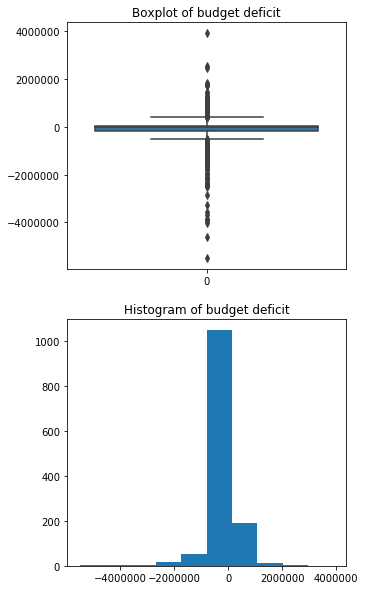

In [20]:
# Creating budget deficit column
plt.figure( figsize = (5,10))

usedu_df['BUDGET_DEFICIT'] = usedu_df['TOTAL_REVENUE'] - usedu_df['TOTAL_EXPENDITURE']
plt.subplot(2,1,1)
sns.boxplot( data = usedu_df['BUDGET_DEFICIT'], orient='v')
plt.title('Boxplot of budget deficit')

plt.subplot(2,1,2)
plt.hist(usedu_df['BUDGET_DEFICIT'])
plt.title('Histogram of budget deficit')
plt.show()

In [21]:
# Checking outliers in budget deficit using Tukey's method

q75, q25 = np.percentile(usedu_df['BUDGET_DEFICIT'] , [75 ,25])
iqr = q75 - q25

print('Budget deficit outliers:')
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((usedu_df['BUDGET_DEFICIT'] > max_val) | (usedu_df['BUDGET_DEFICIT'] < min_val))[0])) ))

Budget deficit outliers:
The score threshold is: 1.0
Number of outliers is: 271
The score threshold is: 1.5
Number of outliers is: 204
The score threshold is: 2.0
Number of outliers is: 152
The score threshold is: 2.5
Number of outliers is: 121
The score threshold is: 3.0
Number of outliers is: 103
The score threshold is: 3.5
Number of outliers is: 84
The score threshold is: 4.0
Number of outliers is: 78
The score threshold is: 4.5
Number of outliers is: 67


In [22]:
# Checking outliers in budget deficit using z-score

budget_z_scores = zscore(usedu_df['BUDGET_DEFICIT'])
print('Budget deficit outliers:')
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(budget_z_scores > threshold)[0]))))

Budget deficit outliers:
The score threshold is: 1
Number of outliers is: 66
The score threshold is: 2
Number of outliers is: 19
The score threshold is: 3
Number of outliers is: 7
The score threshold is: 4
Number of outliers is: 3


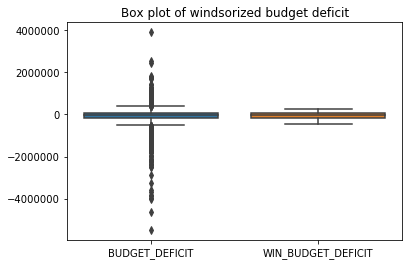

In [23]:
# Cannot log transform because of negative values
# Use winsorization
winsorized_budget = winsorize(usedu_df['BUDGET_DEFICIT'], (0.10, 0.10))

df = pd.DataFrame(list(zip(usedu_df['BUDGET_DEFICIT'], winsorized_budget)), columns =['BUDGET_DEFICIT', 'WIN_BUDGET_DEFICIT']) 
sns.boxplot(data=df)
plt.title("Box plot of windsorized budget deficit")
plt.show()

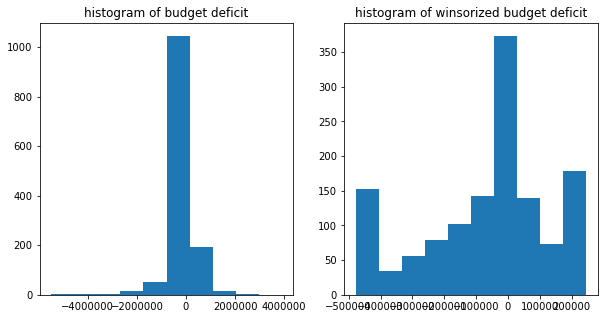

In [24]:
plt.figure( figsize = (10,5))

plt.subplot(1,2,1)
plt.hist(usedu_df['BUDGET_DEFICIT'])
plt.title('histogram of budget deficit')

plt.subplot(1,2,2)
plt.hist(winsorized_budget)
plt.title('histogram of winsorized budget deficit')

plt.show()

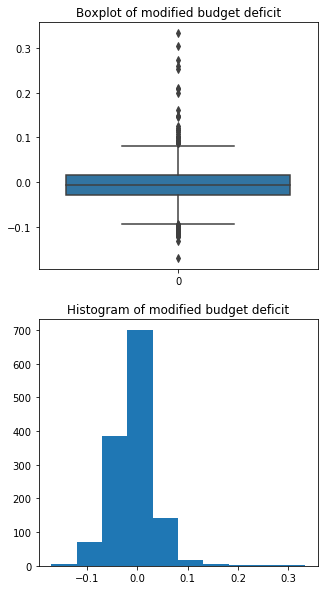

In [25]:
# Creating budget deficit column from modified revenue and expenditure values

plt.figure( figsize = (5,10))

usedu_df['LOG_BUDGET_DEFICIT'] = usedu_df['LOG_TOTAL_REVENUE'] - usedu_df['LOG_TOTAL_EXPENDITURE']
plt.subplot(2,1,1)
sns.boxplot( data = usedu_df['LOG_BUDGET_DEFICIT'], orient='v')
plt.title('Boxplot of modified budget deficit')

plt.subplot(2,1,2)
plt.hist(usedu_df['LOG_BUDGET_DEFICIT'])
plt.title('Histogram of modified budget deficit')
plt.show()

In [26]:
# Checking outliers in modified budget deficit using z-score

log_budget_z_scores = zscore(usedu_df['LOG_BUDGET_DEFICIT'])
print('Budget deficit outliers:')
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(log_budget_z_scores > threshold)[0]))))

Budget deficit outliers:
The score threshold is: 1
Number of outliers is: 138
The score threshold is: 2
Number of outliers is: 30
The score threshold is: 3
Number of outliers is: 13
The score threshold is: 4
Number of outliers is: 8


### There seems to be more outliers when using 'outlier eliminiated' version of revenue and expenditure

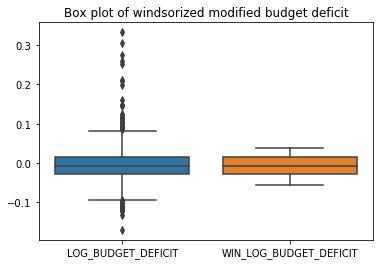

In [27]:
# Winsorize modified budget deficit
winsorized_log_budget = winsorize(usedu_df['LOG_BUDGET_DEFICIT'], (0.10, 0.10))

df = pd.DataFrame(list(zip(usedu_df['LOG_BUDGET_DEFICIT'], winsorized_log_budget)), columns =['LOG_BUDGET_DEFICIT', 'WIN_LOG_BUDGET_DEFICIT']) 
sns.boxplot(data=df)
plt.title("Box plot of windsorized modified budget deficit")
plt.show()

In [28]:
usedu_df[['BUDGET_DEFICIT', 'LOG_BUDGET_DEFICIT']].describe()

,BUDGET_DEFICIT,LOG_BUDGET_DEFICIT
count,1.331000e+03,1331.000000
mean,-1.046004e+05,-0.005858
std,5.665994e+05,0.043523
min,-5.487742e+06,-0.170369
25%,-1.810255e+05,-0.028742
50%,-2.047000e+04,-0.006391
75%,4.897450e+04,0.015066
max,3.897129e+06,0.332627


***
# Data Exploration

In [29]:
usedu_df.describe(include='all')

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,LOG_TOTAL_REVENUE,LOG_TOTAL_EXPENDITURE,BUDGET_DEFICIT,LOG_BUDGET_DEFICIT
count,1331,1331,1331.000000,1.331000e+03,1.331000e+03,1.331000e+03,1.331000e+03,1.331000e+03,1.331000e+03,1.331000e+03,...,1.229000e+03,1.218000e+03,536.000000,532.000000,533.000000,498.000000,1331.000000,1331.000000,1.331000e+03,1331.000000
unique,1326,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2008_VIRGINIA,DISTRICT_OF_COLUMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2004.515402,9.160580e+05,9.092664e+06,7.664310e+05,4.216914e+06,4.109319e+06,9.197265e+06,4.763269e+06,...,2.701086e+05,8.575149e+05,234.768293,278.414711,218.866154,263.661132,15.441708,15.447566,-1.046004e+05,-0.005858
std,NaN,NaN,7.493076,1.064834e+06,1.171056e+07,1.139567e+06,5.527828e+06,5.466576e+06,1.194355e+07,6.274905e+06,...,3.147253e+05,9.886245e+05,10.221511,10.159722,7.769616,6.803725,1.076365,1.080854,5.665994e+05,0.043523
min,NaN,NaN,1992.000000,4.386600e+04,4.656500e+05,3.102000e+04,0.000000e+00,2.209300e+04,4.816650e+05,2.655490e+05,...,2.758000e+03,2.455400e+04,187.134670,232.831510,178.557612,236.379102,13.051190,13.085004,-5.487742e+06,-0.170369
25%,NaN,NaN,1998.000000,2.569087e+05,2.185332e+06,1.899575e+05,1.153090e+06,7.205660e+05,2.165280e+06,1.171336e+06,...,7.611800e+04,2.538248e+05,229.694352,272.761598,214.663401,259.533171,14.597278,14.588060,-1.810255e+05,-0.028742
50%,NaN,NaN,2005.000000,6.490130e+05,5.086083e+06,4.074320e+05,2.542639e+06,2.058996e+06,5.245560e+06,2.659448e+06,...,1.817190e+05,6.088460e+05,237.238552,280.618803,220.416034,265.010912,15.442019,15.472893,-2.047000e+04,-0.006391
75%,NaN,NaN,2011.000000,1.010687e+06,1.084516e+07,8.279320e+05,5.125108e+06,4.768979e+06,1.074420e+07,5.573844e+06,...,3.106070e+05,9.672780e+05,241.995486,285.347428,223.999337,268.190121,16.199230,16.189877,4.897450e+04,0.015066


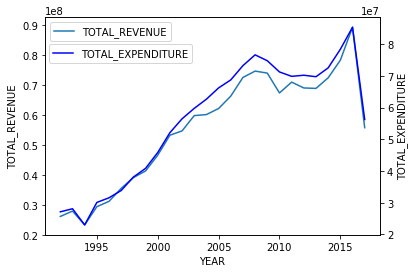

In [30]:
example_state = 'CALIFORNIA'

sns.lineplot(x='YEAR', y='TOTAL_REVENUE', data=usedu_df[usedu_df['STATE'] == example_state], label='TOTAL_REVENUE')
ax2 = plt.twinx()
sns.lineplot(x='YEAR', y='TOTAL_EXPENDITURE', data=usedu_df[usedu_df['STATE'] == example_state], color="b", ax=ax2, label='TOTAL_EXPENDITURE')
plt.legend(bbox_to_anchor=(0.455,0.9))
plt.show()

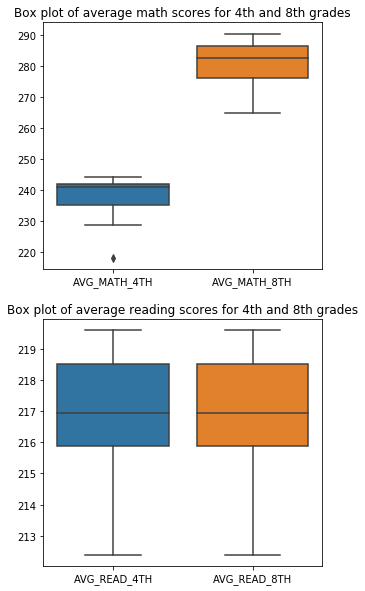

In [31]:
# compare reading vs. math
plt.figure( figsize = (5,10))
usedu_TX = usedu_df[ usedu_df.STATE == 'TEXAS']

plt.subplot(2,1,1)
df = pd.DataFrame(list(zip(usedu_TX['AVG_MATH_4_SCORE'], usedu_TX['AVG_MATH_8_SCORE'])), columns =['AVG_MATH_4TH', 'AVG_MATH_8TH']) 
sns.boxplot(data=df)
plt.title("Box plot of average math scores for 4th and 8th grades")

plt.subplot(2,1,2)
df = pd.DataFrame(list(zip(usedu_TX['AVG_READING_4_SCORE'], usedu_TX['AVG_READING_4_SCORE'])), columns =['AVG_READ_4TH', 'AVG_READ_8TH']) 
sns.boxplot(data=df)
plt.title("Box plot of average reading scores for 4th and 8th grades")
plt.show()


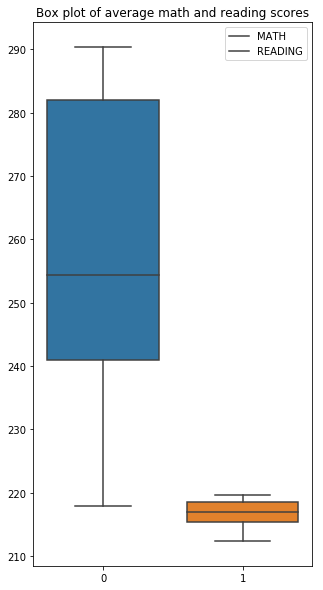

In [32]:
# aggregate 4th and 8th grade data

plt.figure( figsize = (5,10))

df1 = pd.DataFrame(list(zip(usedu_TX['AVG_MATH_4_SCORE'], usedu_TX['AVG_MATH_8_SCORE'])), columns =['AVG_MATH_4TH', 'AVG_MATH_8TH']) 
df2 = pd.DataFrame(list(zip(usedu_TX['AVG_READING_4_SCORE'], usedu_TX['AVG_READING_4_SCORE'])), columns =['AVG_READ_4TH', 'AVG_READ_8TH']) 
sns.boxplot(data = [df1, df2], orient = 'v')
plt.title("Box plot of average math and reading scores")
plt.legend( labels=['MATH', 'READING'])
plt.show()

In [33]:
# Use t-test to check if the difference is significant (even though the sample size is <30)
math_scores = df1[pd.notnull(df1.values.tolist())].values.flatten()
reading_scores = df2[pd.notnull(df2.values.tolist())].values.flatten()
t_val, p_val = scipy.stats.ttest_ind(reading_scores, math_scores, equal_var=False)
print('t = {0}, p = {1}'.format(t_val, p_val))

t = -11.946639648053013, p = 2.343734436318033e-15


### Student are significantly more successful in math in Texas

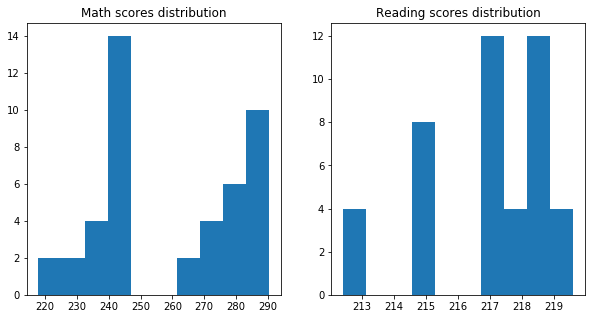

In [34]:
# Distribution of math and reading scores in Texas

plt.figure( figsize = (10,5))

plt.subplot(1,2,1)
plt.hist(math_scores)
plt.title('Math scores distribution')

plt.subplot(1,2,2)
plt.hist(reading_scores)
plt.title('Reading scores distribution')

plt.show()

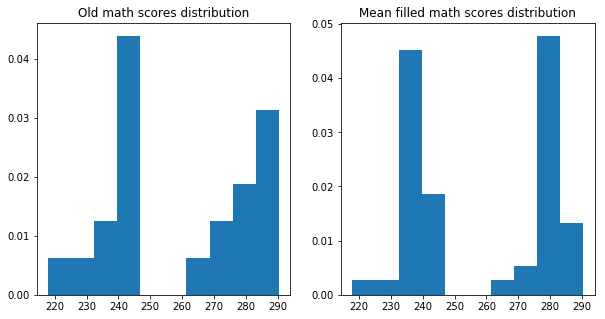

In [39]:
# Filling missing score values using MEAN and checking distribution
usedu_copy = usedu_TX
usedu_copy['AVG_MATH_4_SCORE'] = usedu_copy.groupby('STATE')['AVG_MATH_4_SCORE'].transform(lambda x: x.fillna(x.mean()))
usedu_copy['AVG_MATH_8_SCORE'] = usedu_copy.groupby('STATE')['AVG_MATH_8_SCORE'].transform(lambda x: x.fillna(x.mean()))

math_scores_filled = usedu_copy[['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE']].values.flatten()

plt.figure( figsize = (10,5))
plt.subplot(1,2,1)
plt.hist(math_scores, normed=True)
plt.title('Old math scores distribution')

plt.subplot(1,2,2)
plt.hist(math_scores_filled, normed=True)
plt.title('Mean filled math scores distribution')

plt.show()


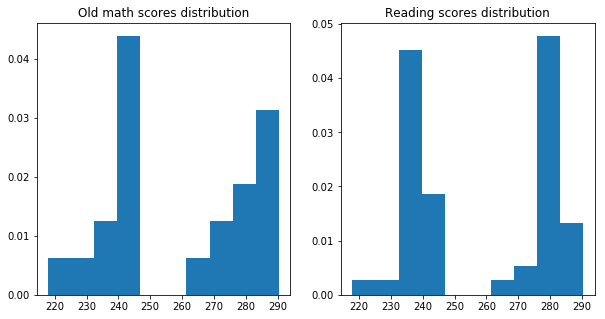

In [46]:
# Filling missing score values using MEDIAN and checking distribution

usedu_copy = usedu_TX
usedu_copy['AVG_MATH_4_SCORE'] = usedu_copy.groupby('STATE')['AVG_MATH_4_SCORE'].transform(lambda x: x.fillna(statistics.median(x)))
                                                                                           
usedu_copy['AVG_MATH_8_SCORE'] = usedu_copy.groupby('STATE')['AVG_MATH_8_SCORE'].transform(lambda x: x.fillna(statistics.median(x)))

math_scores_filled = usedu_copy[['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE']].values.flatten()

plt.figure( figsize = (10,5))
plt.subplot(1,2,1)
plt.hist(math_scores, normed=True)
plt.title('Old math scores distribution')

plt.subplot(1,2,2)
plt.hist(math_scores_filled, normed=True)
plt.title('Reading scores distribution')

plt.show()

In [76]:
# Filling missing score values using Linear Interpolation and checking distribution

### TO BE COMPLETED ###